LOAD THE MODEL AND MARK LABELS ON THE FACE

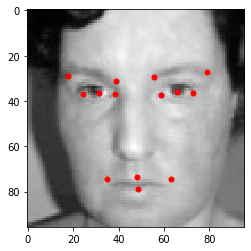

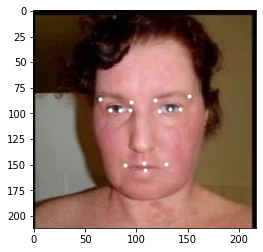

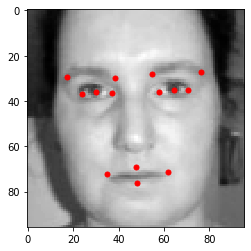

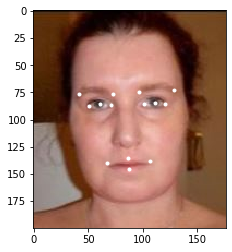

In [5]:
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import time

# Load the saved model
from keras.models import load_model
model = load_model('../model/model1.h5')  # <-- Saved model path


def detect_points(face_img):
    me  = np.array(face_img)/255
    x_test = np.expand_dims(me, axis=0)
    x_test = np.expand_dims(x_test, axis=3)

    y_test = model.predict(x_test)
    label_points = (np.squeeze(y_test)*48)+48 
    
    return label_points

def plot_labels(img):
    # Load haarcascade
    face_cascade = cv2.CascadeClassifier('../conf/opencv_haarcascade/haarcascade_frontalface_default.xml')
    dimensions = (96, 96)

    default_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_img, 1.3, 5)
    # faces = face_cascade.detectMultiScale(gray_img, 4, 6)

    faces_img = np.copy(gray_img)

    plt.rcParams["axes.grid"] = False


    all_x_cords = []
    all_y_cords = []
    all_x_cords_face = []
    all_y_cords_face = []   
    just_face_rgb = []
    just_face = []
    
    for i, (x,y,w,h) in enumerate(faces):

        h += 10
        w += 10
        x -= 5
        y -= 5

        just_face_rgb = cv2.resize(default_img[y:y+h,x:x+w], dimensions)
        just_face = cv2.resize(gray_img[y:y+h,x:x+w], dimensions)
        cv2.rectangle(faces_img,(x,y),(x+w,y+h),(255,0,0),1)

        scale_val_x = w/96
        scale_val_y = h/96

        label_point = detect_points(just_face)
        all_x_cords.append((label_point[::2]*scale_val_x)+x)
        all_y_cords.append((label_point[1::2]*scale_val_y)+y)

        all_x_cords_face.append((label_point[::2]))
        all_y_cords_face.append((label_point[1::2]))


        plt.imshow(just_face, cmap='gray')
        plt.plot(label_point[::2], label_point[1::2], 'ro', markersize=5)
        plt.show()


    plt.imshow(default_img)    
    plt.plot(all_x_cords, all_y_cords, 'wo',  markersize=3)
    plt.show()

    return (default_img, just_face_rgb, all_x_cords_face, all_y_cords_face)

# Enter the path to your test image
participant_id = 8
img_before = cv2.imread('../raw_images/' + str(participant_id) + '_Before.JPG')
img_after = cv2.imread('../raw_images/' + str(participant_id) + '_After.JPG')
(default_img_before, just_face_rgb_before, all_x_cords_before, all_y_cords_before) = plot_labels(img_before)
(default_img_after, just_face_rgb_after, all_x_cords_after, all_y_cords_after) = plot_labels(img_after)

MASK EYES AND MOUTH

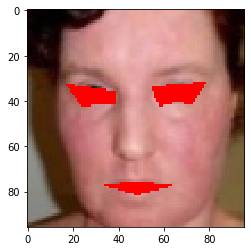

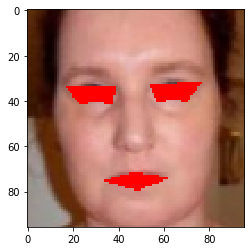

In [6]:
def mask_image(all_x_cords, all_y_cords, default_img):
    rt_eye_pts = np.array([[all_x_cords[0][2],all_y_cords[0][2]+5],[all_x_cords[0][0],all_y_cords[0][0]+5],[all_x_cords[0][3],all_y_cords[0][3]+5],[all_x_cords[0][7],all_y_cords[0][7]+5],[all_x_cords[0][6],all_y_cords[0][6]+5]], np.int32)
    lt_eye_pts = np.array([[all_x_cords[0][1],all_y_cords[0][1]+5],[all_x_cords[0][5],all_y_cords[0][5]+5],[all_x_cords[0][9],all_y_cords[0][9]+5],[all_x_cords[0][8],all_y_cords[0][8]+5],[all_x_cords[0][4],all_y_cords[0][4]+5]], np.int32)
    mth_pts = np.array([[all_x_cords[0][10],all_y_cords[0][10]+3],[all_x_cords[0][12],all_y_cords[0][12]+3],[all_x_cords[0][11],all_y_cords[0][11]+3],[all_x_cords[0][13],all_y_cords[0][13]+3]], np.int32)
    masked_img = cv2.fillPoly(default_img, [rt_eye_pts], 255)
    masked_img = cv2.fillPoly(masked_img, [lt_eye_pts], 255)
    masked_img = cv2.fillPoly(masked_img, [mth_pts], 255)
    plt.imshow(masked_img)
    plt.show()
    
    return masked_img
    
masked_img_before = mask_image(all_x_cords_before, all_y_cords_before, just_face_rgb_before)
masked_img_after = mask_image(all_x_cords_after, all_y_cords_after, just_face_rgb_after)

Identify smoooth, rough and medium areas on the face using LBP algorithm

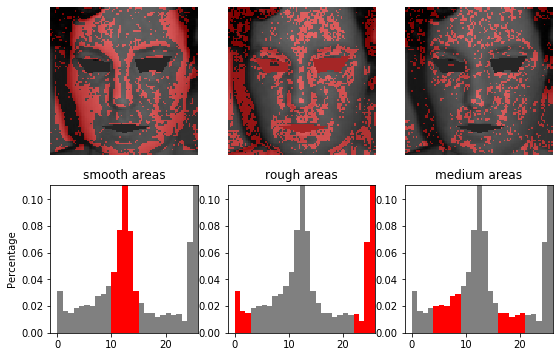

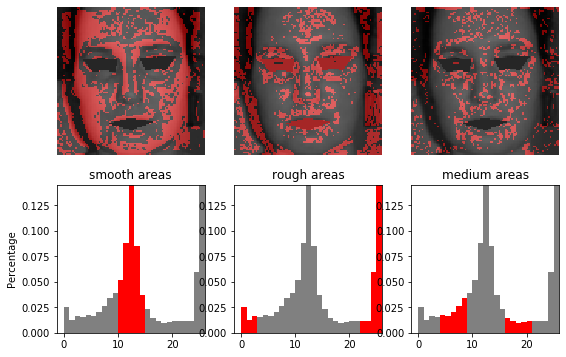

In [7]:
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data
from skimage.color import label2rgb

def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')


def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')


def plot_lbp(image, lbp):
    # plot histograms of LBP of textures
    fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
    plt.gray()

    titles = ('smooth areas', 'rough areas', 'medium areas')
    w = width = radius - 1
    edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
    flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
    i_14 = n_points // 4            # 1/4th of the histogram
    i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
    corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                     list(range(i_34 - w, i_34 + w + 1)))

    label_sets = (edge_labels, flat_labels, corner_labels)

    for ax, labels in zip(ax_img, label_sets):
        ax.imshow(overlay_labels(image, lbp, labels))

    for ax, labels, name in zip(ax_hist, label_sets, titles):
        counts, _, bars = hist(ax, lbp)
        highlight_bars(bars, labels)
        ax.set_ylim(top=np.max(counts[:-1]))
        ax.set_xlim(right=n_points + 2)
        ax.set_title(name)

    ax_hist[0].set_ylabel('Percentage')
    for ax in ax_img:
        ax.axis('off')
        
    return fig
        
# settings for LBP
radius = 3
n_points = 8 * radius
METHOD = 'uniform'

masked_img_before_gray = cv2.cvtColor(masked_img_before, cv2.COLOR_RGB2GRAY)
lbp_before = local_binary_pattern(masked_img_before_gray, n_points, radius, METHOD)
plot_before = plot_lbp(masked_img_before_gray, lbp_before)

masked_img_after_gray = cv2.cvtColor(masked_img_after, cv2.COLOR_RGB2GRAY)
lbp_after = local_binary_pattern(masked_img_after_gray, n_points, radius, METHOD)
plot_after = plot_lbp(masked_img_after_gray, lbp_after)

Save the output plots to pdf

In [8]:
    from matplotlib.backends.backend_pdf import PdfPages

pp = PdfPages('../output/' + str(participant_id) + '_Output.pdf')
pp.savefig(plot_before)
pp.savefig(plot_after)
pp.close()